In [1]:
import numpy as np
import json
import glob
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
from collections import defaultdict
import tqdm 
from Bio.PDB import PDBParser
import warnings
import pickle
import dfs_code
warnings.filterwarnings('ignore')

In [2]:
path = "/mnt/ssd/datasets/enzyme/"

In [3]:
glob.glob(path+"*")

['/mnt/ssd/datasets/enzyme/metadata',
 '/mnt/ssd/datasets/enzyme/pdb_files',
 '/mnt/ssd/datasets/enzyme/parsed.json',
 '/mnt/ssd/datasets/enzyme/parsed.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed_leq4.5.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed_leq4.500000.pkl']

In [4]:
with open(path+"metadata/function_labels.json", "r") as f:
    labels = json.load(f)

In [5]:
with open(path+"metadata/base_split.json", "r") as f:
    split = json.load(f)

In [6]:
with open(path+"parsed.pkl", "rb") as f:
    features = pickle.load(f)

In [7]:
max_dist = 0
max_nodes = 0
nodes = []
selected_keys = []
for prot, feats in tqdm.tqdm(features.items()):
    curr_max = np.max(feats['A'])
    n_nodes = len(feats['A'])
    if n_nodes > max_nodes:
        max_nodes = n_nodes
    if curr_max > max_dist:
        max_dist = curr_max
    if n_nodes <= 200:
        selected_keys += [prot] 
    nodes += [n_nodes]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37428/37428 [00:01<00:00, 20829.12it/s]


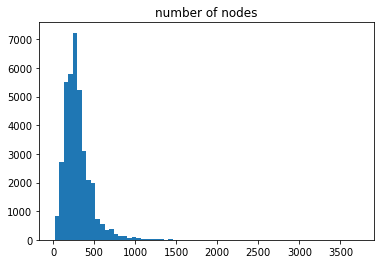

In [8]:
plt.hist(nodes, bins='rice')
plt.title('number of nodes')
plt.show()

In [9]:
bins = np.linspace(0, int(max_dist)+1, 200)
counts = np.zeros(len(bins)-1)

In [10]:
for prot in tqdm.tqdm(selected_keys):
    ds = features[prot]["A"].flatten()
    counts += np.histogram(ds, bins=bins)[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:11<00:00, 929.42it/s]


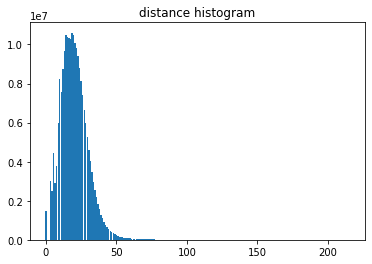

In [11]:
plt.bar(bins[:-1], counts, width=1)
plt.title('distance histogram')
plt.show()

In [12]:
cutoff = 10

In [13]:
n_edges = []
for prot in tqdm.tqdm(selected_keys):
    ds = features[prot]["A"].flatten()
    n_edges += [((ds != 0)*(ds < cutoff)).sum()]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:00<00:00, 25509.88it/s]


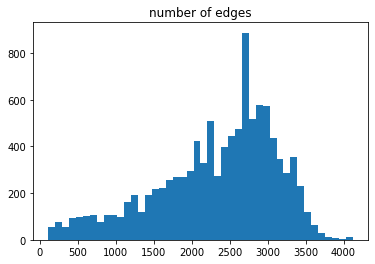

In [14]:
plt.hist(n_edges, bins="rice")
plt.title('number of edges')
plt.show()

In [15]:
bins2 = np.linspace(0, cutoff, 500)
counts2 = np.zeros(len(bins2)-1)

In [16]:
n_edges = []
for prot in tqdm.tqdm(selected_keys):
    ds = features[prot]["A"].flatten()
    counts2 += np.histogram(ds[(ds != 0)*(ds < cutoff)], bins=bins2)[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:01<00:00, 5362.65it/s]


<BarContainer object of 499 artists>

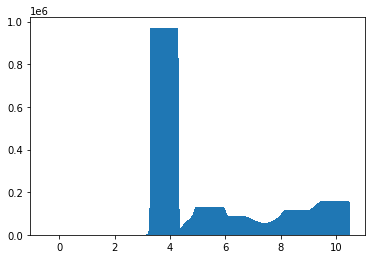

In [17]:
plt.bar(bins2[:-1], counts2, width=1)

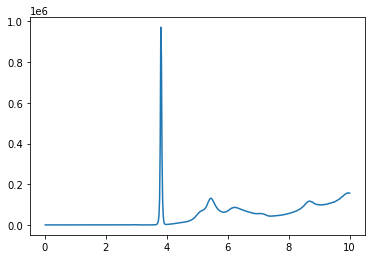

In [18]:
plt.plot(bins2[1:], counts2)

In [19]:
features[prot]

{'pos': array([[ 14.65 ,   5.731,  -0.155],
        [ 13.997,   7.697,  -3.375],
        [ 14.156,  11.109,  -5.046],
        [ 11.228,  13.404,  -4.08 ],
        [  9.234,  14.761,  -7.035],
        [  6.217,  16.987,  -6.546],
        [  3.665,  16.539,  -9.31 ],
        [  0.649,  18.781,  -9.312],
        [ -2.525,  17.931, -11.259],
        [ -4.901,  20.551, -12.609],
        [ -7.915,  20.971, -14.944],
        [-11.706,  21.246, -15.3  ],
        [-14.215,  19.902, -12.823],
        [-14.788,  16.22 , -13.657],
        [-12.069,  15.664, -16.257],
        [-10.709,  12.639, -14.31 ],
        [ -7.799,  14.06 , -12.301],
        [ -8.663,  12.023,  -9.169],
        [ -9.631,   8.78 , -11.022],
        [ -6.377,   8.968, -12.906],
        [ -4.324,   8.943,  -9.657],
        [ -6.435,   6.292,  -7.89 ],
        [ -6.143,   4.102, -10.961],
        [ -2.354,   4.582, -11.102],
        [ -1.602,   3.974,  -7.417],
        [ -4.277,   1.397,  -6.597],
        [ -5.607,   0.132,  -9.

In [20]:
acids = set()
for prot in tqdm.tqdm(selected_keys):
    acids |= set(features[prot]["acid"].tolist())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:00<00:00, 73376.04it/s]


In [21]:
acids2int = {acid:idx for idx, acid in enumerate(list(acids))}

In [22]:
def d2edge_type(d):
    if d<4:
        return 0
    elif d<5:
        return 1
    elif d<6:
        return 2
    elif d<7:
        return 3
    elif d<8:
        return 4
    elif d<9:
        return 5
    elif d<10:
        return 6
    else:
        return 7

In [ ]:
graphs = defaultdict(dict)
exceptions = []
for prot in tqdm.tqdm(selected_keys):
    try:
        D = features[prot]['A']
        A = (D != 0) * (D < cutoff)
        edge_index = np.asarray(np.where(A))
        edge_index_set = set((e[0], e[1]) for e in edge_index.T)
        node_types = np.asarray([acids2int[acid] for acid in features[prot]['acid']])
        glue_edges = []
        for i in range(len(A)-1):
            if (i, i+1) not in edge_index_set:
                glue_edges += [[i, i+1], [i+1, i]]
        if len(glue_edges) > 0:
            glue_edges = np.asarray(glue_edges).T
            edge_index = np.concatenate((edge_index, glue_edges), axis=1)
        edge_types = np.asarray([d2edge_type(D[e[0], e[1]]) for e in edge_index.T])
        min_dfs_code, min_dfs_index = dfs_code.min_dfs_code_from_edgeindex(edge_index, 
                                                                           node_types.tolist(), 
                                                                           edge_types.tolist())
        graphs[prot]['edge_index'] = edge_index
        graphs[prot]['edge_types'] = edge_types
        graphs[prot]['node_types'] = node_types
        graphs[prot]['min_dfs_code'] = min_dfs_code
        graphs[prot]['min_dfs_index'] = min_dfs_index
        graphs[prot]['pos'] = features[prot]['pos']
    except:
        print('%s failed'%prot)
        exceptions += [prot]
        continue

 10%|█████████████████                                                                                                                                                        | 1054/10478 [00:40<05:45, 27.31it/s]

In [ ]:
trainset = set(split['train'])
validset = set(split['valid'])
testset = set(split['test'])

In [ ]:
for key in graphs.keys():
    graphs[key]['label'] = labels[key]
    if key in trainset:
        graphs[key]['split'] = "train"
    elif key in validset:
        graphs[key]['split'] = "valid"
    elif key in testset:
        graphs[key]['split'] = "test"
    else:
        raise ValueError("unexpected")

In [ ]:
with open(path+"min_dfs_transformer_preprocessed_leq%f.pkl"%cutoff, "wb") as f:
    pickle.dump(graphs, f)